# Task 2: Sentiment Analysis on Amazon Product Reviews

**Task Overview**
**Objective:** Create a sentiment analysis classifier to label reviews as positive, neutral, or negative.

**Deliverables:**

- Preprocessing pipeline (tokenization, stopword removal)
- Labeled dataset and train/test sets
- Model training (Naive Bayes, LSTM, or BERT)
- Visualization of word clouds and confusion matrix

**Mock Data (Python):**

from faker import Faker

import random



fake = Faker()

reviews = [fake.text(max_nb_chars=200) for _ in range(5000)]

labels = [random.choice(['positive', 'neutral', 'negative']) for _ in range(5000)]

# 1. Data Generation

- First, we will a mock data set of 5000 reviews using the `Faker` library.
- The we will asign each review a 'positive', 'neutral' or 'negative' label.

In [1]:
# # installing faker
# !pip install faker

In [2]:
import pandas as pd
from faker import Faker
import numpy as np

# initiating faker
fake = Faker()

# generating mock data
total_reviews = 5000
reviews = [fake.text(max_nb_chars=200) for _ in range(total_reviews)]
labels = [np.random.choice(["positive", "neutral", "negative"]) for _ in range(total_reviews)]

# Create a Dataframe
df = pd.DataFrame({"review":reviews, "sentiment":labels})
print("Dataset created successfully!")

Dataset created successfully!


In [3]:
# displaying data
df.head()

,review,sentiment
0,National wife hit. Prepare rock challenge book...,positive
1,Exist stage soon standard already happen appea...,positive
2,Plant trial difference. Big keep herself hold....,negative
3,Give law kid. Test consider figure wear mouth ...,positive
4,Edge perhaps him ask example ask score radio. ...,neutral


In [4]:
# sentiment distribution
df["sentiment"].value_counts()

sentiment
neutral     1738
positive    1642
negative    1620
Name: count, dtype: int64

In [5]:
# sentiment distribution
df["sentiment"].value_counts()

sentiment
neutral     1738
positive    1642
negative    1620
Name: count, dtype: int64

**Observation:** Data is balanced, as each label has almost equal samples. 

# 2. Preprocessing pipeline

## 2.0 Importing Necessary Libraries

In [6]:
import re
import nltk
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, GridSearchCV
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer


# # Make sure NLTK data is available
# nltk.download("punkt")
# nltk.download("punkt_tab")
# nltk.download("stopwords")

# Plain stopwords list (picklable)
stop_words = set(stopwords.words("english"))

## 2.1 Splitting Data into Train and Test Datasets

In [7]:
# X : Features and y: Target Labels
X, y = df["review"], df["sentiment"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=42, stratify=y, test_size=0.2
)

## 2.3 Naive Bayes Model Training

### Text Preprocessing

In [8]:
# Preprocessing function (no class)
def preprocess_texts(texts):
    def clean(text):
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        text = text.lower()
        tokens = word_tokenize(text)
        return ' '.join([word for word in tokens if word not in stop_words])
    return pd.Series(texts).apply(clean)

### Model Training

In [9]:
# Pipeline with FunctionTransformer
pipeline = Pipeline([
    ("preprocess", FunctionTransformer(preprocess_texts, validate=False)),
    ("tfidf", TfidfVectorizer()),
    ("nb", MultinomialNB())
])

# GridSearch hyperparameters
param_grid = {
    'tfidf__ngram_range': [(1,1), (1,2)],
    'tfidf__max_df': [0.9, 1.0],
    'tfidf__min_df': [1, 2],
    'tfidf__max_features': [None, 3000],
    'nb__alpha': [0.1, 1.0, 5.0]
}

# GridSearchCV
nb_grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring="accuracy",
    cv=5,
    n_jobs=-1,  # Use all cores
    verbose=2
)

# Fit the model
nb_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


,estimator,Pipeline(step...inomialNB())])
,param_grid,"{'nb__alpha': [0.1, 1.0, ...], 'tfidf__max_df': [0.9, 1.0], 'tfidf__max_features': [None, 3000], 'tfidf__min_df': [1, 2], ...}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,5
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,func,<function pre...001CE92EBCC10>


## 2.4 LSTM Model Training

### Preprocessing

In [10]:
from keras.utils import pad_sequences
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout


# Tokenize the text
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=200, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=200, padding='post')

# Encode labels
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_test_enc = label_encoder.transform(y_test)


In [11]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout

model_lstm = Sequential([
    Embedding(input_dim=10000, output_dim=64, input_length=200),
    LSTM(64, return_sequences=False),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dense(3, activation='softmax')
])

model_lstm.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model_lstm.fit(X_train_pad, y_train_enc, epochs=5, batch_size=32, validation_split=0.2)


d:\AWFERA\Skilled Score\Data Science Internship\ds_env\lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 60ms/step - accuracy: 0.3179 - loss: 1.0997 - val_accuracy: 0.3388 - val_loss: 1.0994
Epoch 2/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.3301 - loss: 1.1017 - val_accuracy: 0.3388 - val_loss: 1.0991
Epoch 3/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.3468 - loss: 1.0981 - val_accuracy: 0.3388 - val_loss: 1.0996
Epoch 4/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.3564 - loss: 1.0974 - val_accuracy: 0.3388 - val_loss: 1.0994
Epoch 5/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.3449 - loss: 1.0987 - val_accuracy: 0.3388 - val_loss: 1.1007


# 3. Model Evaluation and Concusion Matrix

Now, we evaluate our trained model on the unseen test data.

- **Predictions:** We use the trained model to predict sentiments for the test set.
- **Classification Report:** This gives us precision, recall, and F1-score for each class, providing a more detailed performance view.
- **Confusion Matrix:** This is a key deliverable. It visualizes the model's performance by showing where it gets predictions right and where it gets them wrong (e.g., how many 'negative' reviews were incorrectly labeled as 'positive').
- **Word Clouds:** A word cloud is a visual representation of text data where the size of each word is proportional to its frequency in the text. This helps us quickly identify the most prominent terms associated with positive, neutral, and negative reviews.

## 3.1 Confusion Matrix of Niave Bayes

Classification Report of Naive Bayes Model:
              precision    recall  f1-score   support

    positive       0.28      0.06      0.10       328
     neutral       0.35      0.89      0.50       348
    negative       0.26      0.03      0.05       324

    accuracy                           0.34      1000
   macro avg       0.29      0.33      0.22      1000
weighted avg       0.29      0.34      0.22      1000



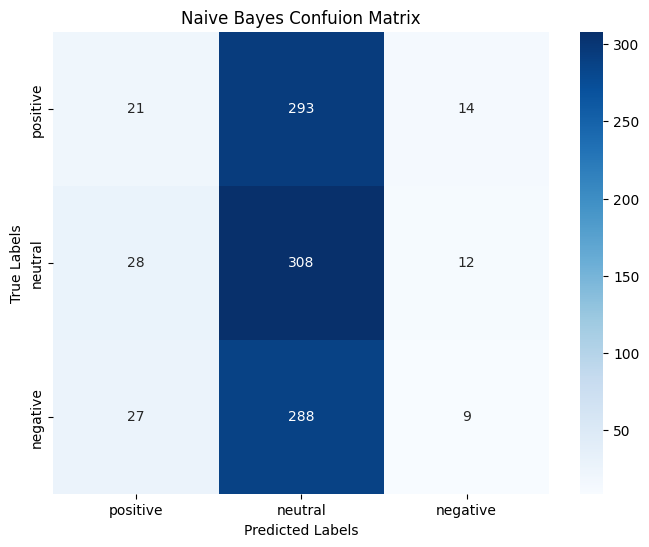

In [12]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# saving model
modeb_nb = nb_grid_search.best_estimator_

# making predictions on test data
y_pred_nb = modeb_nb.predict(X_test)

# print classification report
print("Classification Report of Naive Bayes Model:")
print(classification_report(y_test, y_pred_nb, labels=["positive","neutral","negative"]))

# Generate and Visualize the confusion matrix
cm = confusion_matrix(y_test, y_pred_nb, labels=['positive', 'neutral', 'negative'])
plt.figure(figsize=(8,6))
sns.heatmap(data=cm, annot=True, cmap="Blues", fmt="d", xticklabels=["positive","neutral","negative"], yticklabels=["positive","neutral","negative"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Naive Bayes Confuion Matrix")
plt.show()


In [13]:
label_encoder.transform(["negative","neutral","positive"])

array([0, 1, 2])

## 3.3 Words Clound

Words cloud are great way to visualize the most frequent word in the body of text. We will generate one for each sentiment to see if certain words are more prominent in positive, neutral or negative reviews.

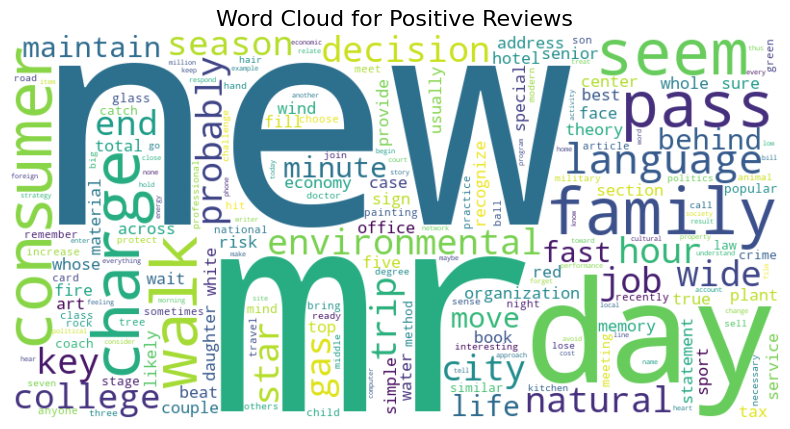

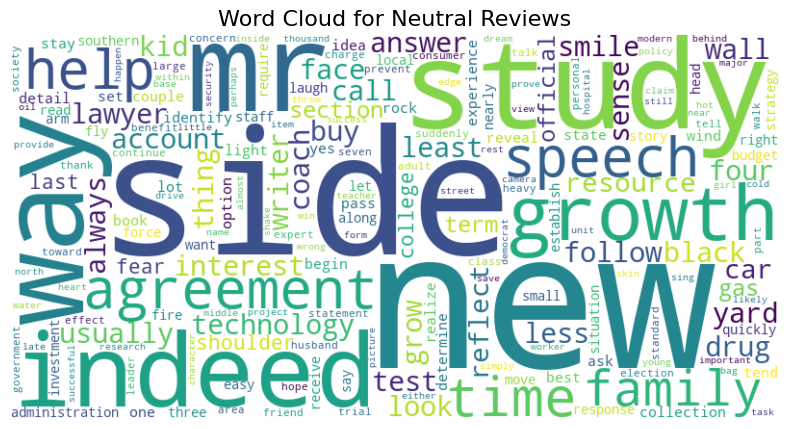

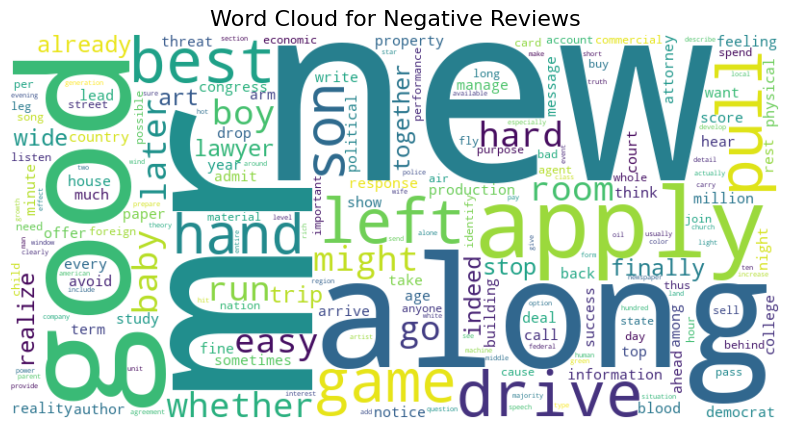

In [14]:
from wordcloud import WordCloud

# processing reviews for word cloud
df["preprocessed_reviews"] = preprocess_texts(df["review"])

# this function generates word cloud for certain category
def generate_word_cloud(sentiment_category):
    """
    Generate and displays a word cloud for a given sentiment.
    """
    text = " ".join(review for review in df[df["sentiment"] == sentiment_category]["preprocessed_reviews"])
    wordcloud_ = WordCloud(width=800, height=400, background_color="white", colormap="viridis").generate(text=text)

    plt.figure(figsize=(10,5))
    plt.imshow(wordcloud_, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud for {sentiment_category.capitalize()} Reviews", fontsize=16)
    plt.show()

# generate word cloud for each category
generate_word_cloud("positive")
generate_word_cloud("neutral")
generate_word_cloud("negative")